In [1]:
import random
from models import deck
from scipy.stats import multivariate_hypergeom, hypergeom, nhypergeom
from matplotlib import pyplot


Specify the filesystem path in `filepath` variable, then load the deck into memory

In [2]:
filepath = "./deck/madolche.txt"
mydeck = deck.Deck.from_file(filepath)

./deck/madolche_temp.txt


FileNotFoundError: [Errno 2] No such file or directory: './deck/madolche_temp.txt'

Validate the total cards of each type:

In [ ]:
def total_count(cards):
    return sum([
        i.count
        for i in cards
    ])

bricks = mydeck.cards_by_deck_type(deck.DeckCardType.BRICK)
non_engine = mydeck.cards_by_deck_type(deck.DeckCardType.NONENGINE)
engine = mydeck.cards_by_deck_type(deck.DeckCardType.ENGINE)

print(f"Your deck has {total_count(bricks)} bricks, {total_count(non_engine)} non-engine, and {total_count(engine)} engine out of {mydeck.size} cards")

Your deck has 7 bricks, 18 non-engine, and 17 engine out of 42 cards


Chance to see any 1 card combo:

In [ ]:
one_card = list(filter(lambda x: len(x.cards) == 1, mydeck.combos))
one_card_cards = set([ card for combo in one_card for card in combo.cards])
total_one_card = sum([
    i.count
    for combo in one_card for i in combo.cards
])
one_card_pv = nhypergeom.pmf(0, mydeck.size, total_one_card, 5)
print(f"All 1 card combos: {one_card_cards}")
print(f"You'll see a 1 card combo in {(1-one_card_pv)*100}% of hands")

All 1 card combos: {noh_punk_ze_amin, madolche_anjelly, emergency_teleport, madolche_petingcessour}
You'll see a 1 card combo in 76.32730983180281% of hands


Chance to see any 2 card combo:
1. Find all discrete cards in all the combos
2. Calculate the probability that the hand has 0 of the cards in the combo
3. For each combo, calculate that only one of the cards is present in the hand

In [ ]:
two_card = list(filter(lambda x: len(x.cards) == 2, mydeck.combos))
cards_in_two_card = set(
    [
        card for combo in two_card for card in combo.cards
    ]
)
# Find hands where none of the cards from the combo are in it at all
total_no_card = sum([
    i.count for i in cards_in_two_card
])
no_cards = hypergeom.cdf(0, mydeck.size, total_no_card, 5)
# For each card in 2 card combos, calculate exactly once the probablility of seeing one 
# card from the combo and not the other.
combos_calculated = {}
for card in cards_in_two_card:
    # Find all combos with this card
    combos = list(filter(
        lambda x: card in x.cards,
        two_card
    ))
    for combo in combos:
        if combo in combos_calculated.keys():
            continue
        total = sum([
            i.count for i in combo.cards
        ])
        total_card = combo.cards[0].count
        total_other_card = combo.cards[1].count
        rv = multivariate_hypergeom(m=[total_card, total_other_card, mydeck.size - total_other_card - total_card], n=5)
        p_1 = sum([
            rv.pmf([x,0,5-x]) for x in range(1,total_card)
        ])
        p_2 = sum([
            rv.pmf([0,x,5-x]) for x in range(1,total_other_card)
        ])
        p_0 = rv.pmf([0,0,5])
        combos_calculated[combo] = 1 - (p_1 + p_2 + p_0)
for combo, prob in combos_calculated.items():
    print(f"You'll see {combo} in {prob*100}% of hands")

You'll see madolche_messangelato + emergency_teleport in 7.198578058655314% of hands
You'll see madolche_messangelato + emergency_teleport in 7.198578058655314% of hands
You'll see madolche_anjelly + madolche_petingcessour in 9.09943714821777% of hands
You'll see madolche_anjelly + vernusylph_of_the_misting_seedlings in 9.09943714821777% of hands
You'll see madolche_hootcake + vernusylph_of_the_misting_seedlings in 7.198578058655314% of hands
You'll see vernusylph_of_the_misting_seedlings + noh_punk_ze_amin in 11.987402841061623% of hands
You'll see vernusylph_of_the_misting_seedlings + noh_punk_deer_note in 11.987402841061623% of hands
You'll see vernusylph_of_the_misting_seedlings + noh_punk_foxy_tune in 11.987402841061623% of hands
You'll see vernusylph_of_the_misting_seedlings + ash_blossom_and_joyous_spring in 9.09943714821777% of hands
You'll see vernusylph_of_the_misting_seedlings + ghost_ogre_and_snow_rabbit in 7.198578058655314% of hands
You'll see vernusylph_of_the_misting_se

Chance to brick with half of a 2 card combo, and no one card combos:

In [ ]:
# Find all cards in combos
cumulative_probability = 1
cards_in_combos = set([
    card for combo in mydeck.combos for card in combo.cards
])
total = sum([
    i.count for i in cards_in_combos
])
chance_to_see_zero = hypergeom.pmf(0, mydeck.size, total, 5)
cumulative_probability = cumulative_probability - chance_to_see_zero
print(f"Chance to see 0 combo cards: {chance_to_see_zero*100}%")
# Find 2 card combos that do not include 1 card combos
unique_two_card = list(filter(
    lambda x: len(one_card_cards.intersection(set(x.cards))) == 0,
    mydeck.combos
))
# Get all unique cards in 2 card combos, calculate the odds of see it, but not the counterpart
cards_in_unique_two_card = set([
    card for combo in unique_two_card for card in combo.cards
])
for card in cards_in_unique_two_card:
    # Find combos for card
    combos = list(filter(
        lambda x: card in x.cards,
        unique_two_card
    ))
    if len(combos) == 1:
        continue
    other_cards = set([
        card for combo in combos for card in combo.cards
    ]).difference([card])
    total_other_card = sum([
        i.count for i in other_cards.union(one_card_cards)
    ])
    rv = multivariate_hypergeom(
        m=[card.count, total_other_card, mydeck.size - total_other_card - card.count],
        n=5
        )
    p = sum([
        rv.pmf([x,0,5-x]) for x in range(1,card.count+1)
    ])
    print(f"Chance to see hands with {card.name}, but nothing needed to play: {p*100}%")

Chance to see 0 combo cards: 0.014811889009578357%
Chance to see hands with vernusylph_of_the_misting_seedlings, but nothing needed to play: 0.18103419900595746%
Chance to see hands with madolche_hootcake, but nothing needed to play: 3.8205269270737743%
Chance to see hands with noh_punk_foxy_tune, but nothing needed to play: 1.7574423864539361%


Run a simulation. Input the number of hands to draw in `N`, then see how many have a one-card or two card combo: 

In [ ]:
N = 120
hands = [
    tuple(random.sample(mydeck.get_simulated_cards(), 5))
    for _ in range(0,N)
]
hands_with_combo = set()
for combo in mydeck.combos:
    in_hands = []
    cards: set = set(combo.cards)
    for hand in hands:
        if cards.issubset(hand):
            in_hands.append(hand)
            hands_with_combo.add(hand)
    print(f"Combo {combo} in {len(in_hands)} out of {len(hands)}")
bricks = set(hands).difference(hands_with_combo)

Combo madolche_anjelly in 31 out of 120
Combo madolche_petingcessour in 34 out of 120
Combo noh_punk_ze_amin in 9 out of 120
Combo emergency_teleport in 33 out of 120
Combo madolche_anjelly + madolche_petingcessour in 6 out of 120
Combo madolche_hootcake + vernusylph_of_the_misting_seedlings in 4 out of 120
Combo vernusylph_of_the_misting_seedlings + noh_punk_ze_amin in 4 out of 120
Combo vernusylph_of_the_misting_seedlings + noh_punk_deer_note in 3 out of 120
Combo vernusylph_of_the_misting_seedlings + noh_punk_foxy_tune in 3 out of 120
Combo vernusylph_of_the_misting_seedlings + ash_blossom_and_joyous_spring in 13 out of 120
Combo vernusylph_of_the_misting_seedlings + ghost_ogre_and_snow_rabbit in 7 out of 120
Combo vernusylph_of_the_misting_seedlings + effect_veiler in 13 out of 120
Combo vernusylph_of_the_misting_seedlings + herald_of_orange_light in 15 out of 120
Combo vernusylph_of_the_misting_seedlings + nibiru_the_primal_being in 12 out of 120
Combo vernusylph_of_the_misting_se

In [ ]:
print(f"{len(bricks)} hands are bricks:")

22 hands are bricks:


In [ ]:
for brick in bricks:
    print(brick)

(herald_of_orange_light, ghost_ogre_and_snow_rabbit, ghost_ogre_and_snow_rabbit, madolche_puddingcess, noh_punk_foxy_tune)
(psy_frame_driver, madolche_puddingcess, ash_blossom_and_joyous_spring, noh_punk_foxy_tune, madolche_promenade)
(ash_blossom_and_joyous_spring, noh_punk_deer_note, madolche_messangelato, infinte_impermenance, infinte_impermenance)
(ash_blossom_and_joyous_spring, madolche_promenade, noh_punk_deer_note, nibiru_the_primal_being, herald_of_orange_light)
(madolche_messangelato, infinte_impermenance, psy_frame_driver, madolche_puddingcess, ash_blossom_and_joyous_spring)
(ghost_ogre_and_snow_rabbit, noh_punk_foxy_tune, madolche_chateau, nibiru_the_primal_being, madolche_puddingcess)
(herald_of_orange_light, herald_of_orange_light, ash_blossom_and_joyous_spring, madolche_puddingcess, nibiru_the_primal_being)
(nibiru_the_primal_being, ghost_ogre_and_snow_rabbit, madolche_hootcake, madolche_messangelato, psy_framegear_gamma)
(infinte_impermenance, ash_blossom_and_joyous_spri

Hands that had any number of distinct non-engine:

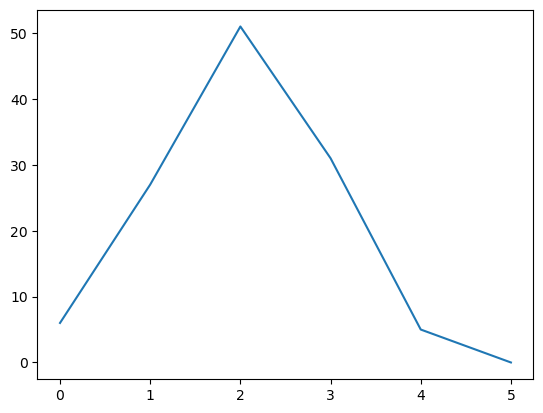

In [ ]:
x = [0,1,2,3,4,5]
y = [0,0,0,0,0,0]
for hand in hands:
    unique_cards = set(hand)
    ne = list(filter(lambda x: x.deck_type == deck.DeckCardType.NONENGINE, unique_cards))
    idx = len(ne)
    y[idx] += 1
pyplot.plot(x,y)